In [1]:
# the necessary R package for generating Laplace distributed random variables
install.packages("VGAM")
library("VGAM")

generate_laplace <- function(n, theta_0){
  # generate n iid Laplace random variables with mean theta_0 and variance 1
  sample = rlaplace(n, location = theta_0, scale = 1)
  sample = pmin(pmax(sample,-5),5) # thresholding to avoid numeric issues
  return(sample)
}

Warning message:
“unable to access index for repository https://cran.r-project.org/src/contrib:
  cannot open URL 'https://cran.r-project.org/src/contrib/PACKAGES'”
Warning message:
“package ‘VGAM’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [ ]:
theta_0 = 0.5  # true location parameter
n_set = c(20,50,100,200,500,1000)  # set of sample sizes in the experiment
mc_times = 20  # number of Monte Carlo simulations

In [ ]:
# this function estimates the density f(x) based on the sample
# bw is the bandwidth parameter used in the computation
density_est <- function(x, sample, bw) {
  x = x + median(sample)
  return( mean(dnorm(x - sample, sd = sqrt(bw))) )
}

# this function estimates the density derivative f'(x) based on the sample
# bw is the bandwidth parameter used in the computation
density_deriv_est <- function(x, sample, bw) {
  x = x + median(sample)
  return( mean(-((x-sample)/(bw^2)) * dnorm(x - sample, sd = sqrt(bw))))
}

# this function outputs the semiparametric estimate of theta_0
semiparametric_estimate <- function(sample){
  bw = density(sample)$bw # set the bandwidth parameter

  # YOUR CODE (5-10 lines):
  # based on the estimates of the density and derivative, use Stein's estimating
  # equation to compute the semiparametric estimate of theta_0
  #
  # Note: the "uniroot" function finding the zero of a 1D function might be useful:
  # https://stat.ethz.ch/R-manual/R-devel/library/stats/html/uniroot.html
  # In uniroot, you may set interval = c(-10, 10)
  # Stein's estimating equation
  steins_equation <- function(theta) {
    f_hat = density_est(theta, sample, bw)
    f_prime_hat = density_deriv_est(theta, sample, bw)
    return(f_prime_hat + (mean(sample) - theta) * f_hat)
  }
  
  # Find the root of Stein's equation
  # The interval is set where we expect the root to be found
  root = uniroot(steins_equation, interval = c(-10, 10))
  
  # The root's $root element gives us the estimate of theta_0
  theta_0_estimate = root$root
  return(theta_0_estimate)
}


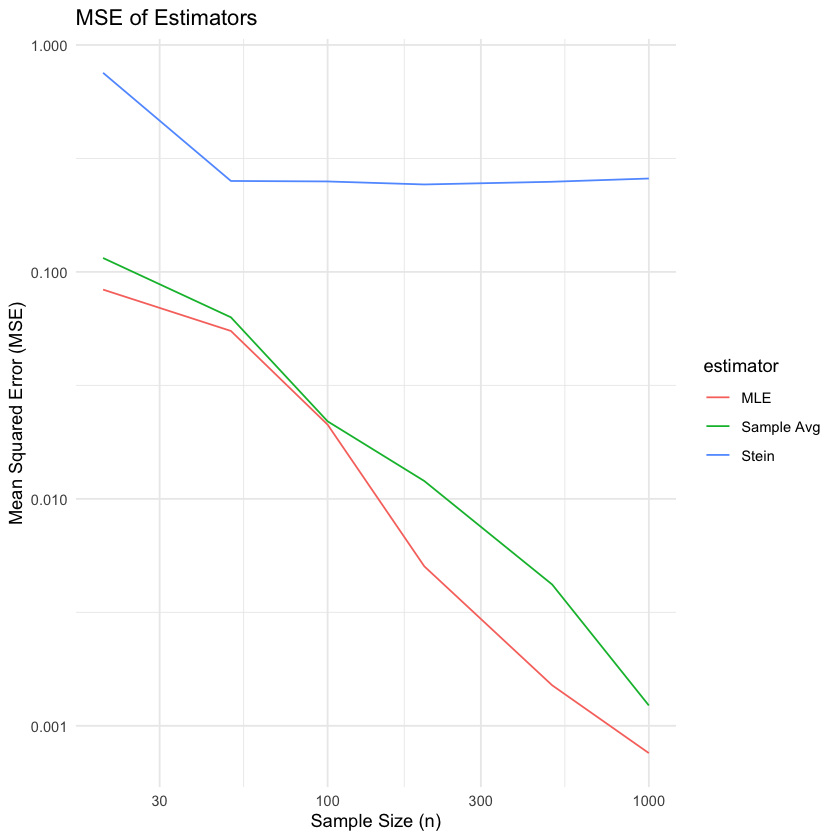

In [ ]:
library("ggplot2")
set.seed("2023")
mse_data <- data.frame(n = integer(), estimator = character(), mse = numeric())

for (n in n_set) {
  mse_estimates <- matrix(0, nrow = mc_times, ncol = 3)
  for (i in 1:mc_times) {
    # Generate a sample of size n
    sample <- rlaplace(n, location = theta_0, scale = 1)
    
    # Compute the estimators
    sample_mean <- mean(sample)
    mle <- median(sample) # For Laplace distribution, MLE is the median
    stein_estimate <- semiparametric_estimate(sample) # Assuming function exists
    
    # Compute squared errors
    mse_estimates[i, 1] <- (sample_mean - theta_0)^2
    mse_estimates[i, 2] <- (mle - theta_0)^2
    mse_estimates[i, 3] <- (stein_estimate - theta_0)^2
  }
  # Calculate the mean squared error for each estimator
  mse_data <- rbind(mse_data, data.frame(n = rep(n, 3), 
                                         estimator = rep(c("Sample Mean", "MLE", "Stein's Estimator"), each = mc_times), 
                                         mse = c(mean(mse_estimates[, 1]), 
                                                 mean(mse_estimates[, 2]), 
                                                 mean(mse_estimates[, 3]))))
}

# Plotting the mean squared error against n on a log-log scale
mse_plot <- ggplot(mse_data, aes(x = n, y = mse, color = estimator)) +
  geom_line() +
  scale_x_log10() +
  scale_y_log10() +
  labs(title = "Mean Squared Error of Estimators",
       x = "Sample Size (n)",
       y = "Mean Squared Error (MSE)",
       color = "Estimator") +
  theme_minimal()

print(mse_plot)

# YOUR CODE (~20 lines):
# 1. for each value n in n_set, generate a sample of size n with truth theta_0
# 2. compute three estimators based on the sample:
### 2.1. the sample average;
### 2.2. the MLE with known f (you are supposed to derive the MLE in this case
### by hand, which should be a very simple function of the sample)
### 2.3. Stein's semiparametric estimator.
# 3. repeat the above procedure for mc_times=20 times, and output the mean
# squared error for each (n, estimator) pair (so 6*3 matrix in total)
# 4. use ggplot, draw (mean squared error ~ n) in a line chart with log-log scale;
# all three curves for different estimators should be in te same plot
# Note: the overall runtime might take several minutes, so it is advised to
# start from small-scale experiments
